# Thai Food Classification with Huggingface's transformers

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ai-builders/curriculum/blob/main/notebooks/04v_classification_transformers.ipynb)

ใน Notebook นี้เราจะโหลดชุดข้อมูลอาหารไทย 50 ชนิด สร้าง datasets และจะใช้วิธีการ fine-tune โมเดล Swin transformer tiny เพื่อแบ่งประเภทภาพอาหารไทย 50 ชนิด

อ่านเพิ่มเติม: [huggingface datasets](https://huggingface.co/docs/datasets/image_load)

In [ ]:
!pip install datasets
!pip install git+https://github.com/huggingface/transformers
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-sbzfbmls
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-sbzfbmls
  Resolved https://github.com/huggingface/transformers to commit 48bef3a734d432ae058983b4448db1ce19f69565
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download datasets

- ดาวน์โหลด FoodyDudy dataset จาก github
- จากนั้นใช้ `load_dataset("imagefolder", ...)` เพื่ออ่านข้อมูลมาใน class `Dataset`
- ทำการโหลด feature extractor ของโมเดลที่จะใช้ fine-tune เพื่อใช้ในการปรับขนาดของภาพ

In [ ]:
!git clone https://github.com/GemmyTheGeek/FoodyDudy.git

Cloning into 'FoodyDudy'...
remote: Enumerating objects: 14727, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 14727 (delta 7), reused 4 (delta 1), pack-reused 14709
Receiving objects: 100% (14727/14727), 645.40 MiB | 26.78 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Updating files: 100% (14465/14465), done.


In [ ]:
food_list = [
    'green_curry', 'tepo_curry', 'liang_curry', 'taohoo_moosup', 'mara_yadsai',
    'masaman', 'orange_curry', 'cashew_chicken', 'omelette', 'sunny_side_up',
    'palo_egg', 'sil_egg', 'nun_banana', 'kua_gai', 'cabbage_fish_sauce',
    'river_prawn', 'shrimp_ob_woonsen', 'kanom_krok', 'mango_sticky_rice', 'kao_kamoo',
    'kao_klook_kapi', 'kaosoi', 'kao_pad', 'kao_pad_shrimp', 'chicken_rice',
    'kao_mok_gai', 'tom_ka_gai', 'tom_yum_kung', 'tod_mun', 'poh_pia',
    'pak_boong_fai_daeng', 'padthai', 'pad_krapao', 'pad_si_ew', 'pad_fakthong',
    'eggplant_stirfry', 'pad_hoi_lai', 'foithong', 'panaeng', 'yum_tua_ploo',
    'yum_woonsen', 'larb_moo', 'pumpkin_custard', 'sakoo_sai_moo', 'somtam',
    'moopoing','satay', 'hor_mok'
]
id2food = {str(i).zfill(2): f for i, f in enumerate(food_list)}

In [ ]:
from datasets import load_dataset, load_metric

In [ ]:
dataset = load_dataset("imagefolder", data_dir="FoodyDudy/images")
accuracy = load_metric("accuracy")

Resolving data files:   0%|          | 0/11520 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1440 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1440 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-08e5d7af8a7534be/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-5-87cdaa45b993>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy")


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 11520
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1440
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1440
    })
})

In [ ]:
from transformers import AutoFeatureExtractor

model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feat_size = tuple(feature_extractor.size.values())
feature_extractor

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

จากนั้นสร้าง `preprocess_train` และ `preprocess_val` เพื่อ preprocess ข้อมูลภาพในแต่ละ batch ของเรา จะเห็นว่าภาพของเราอยู่ใน key ที่ชื่อว่า `image` และเมื่อเรา preprocess ภาพเรียบร้อยจะเก็บไว้ใน key ที่ชื่อว่า `pixel_values`

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    RandomAffine,
    ColorJitter,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose([
    Resize(feat_size),
    RandomResizedCrop(feat_size, scale=(0.8, 1.2)),
    ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

val_transforms = Compose([
    Resize(feat_size),
    ToTensor(),
    normalize,
])


def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
dataset["train"].set_transform(preprocess_train)
dataset["validation"].set_transform(preprocess_val) 

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
id2label[2]

'02'

## Fine-tune our model

- โหลดโมเดลจาก huggingface hub
- สร้าง training arguments
- จากนั้นเทรนและเซฟโมเดล

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([48, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([48]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 32

In [ ]:
args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

In [ ]:
import torch
import numpy as np

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.071200,0.756733,0.815972
2,0.481400,0.315282,0.921528
3,0.348200,0.245470,0.938194


TrainOutput(global_step=270, training_loss=1.1702346978364166, metrics={'train_runtime': 789.0974, 'train_samples_per_second': 43.797, 'train_steps_per_second': 0.342, 'total_flos': 8.601271252077773e+17, 'train_loss': 1.1702346978364166, 'epoch': 3.0})

In [ ]:
trainer.save_model(f"trained/{model_name}")
# alternatively use trainer.push_to_hub instead

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9382
  eval_loss               =     0.2455
  eval_runtime            = 0:00:13.87
  eval_samples_per_second =    103.759
  eval_steps_per_second   =      3.242


## Prediction: Using feature extractor and model

การใช้โมเดลที่เทรนเรียบร้อยแล้วมาทำนายภาพประกอบด้วย `AutoFeatureExtractor` และ `AutoModelForImageClassification` ทั้งนี้สามารถโหลดโมเดลจากโฟลเดอร์ที่เทรนเสร็จเรียบร้อยแล้ว หรือโหลดจาก huggingface hub ก็ได้ ในตัวอย่างนี้เราจะโหลดจากโฟล์เดอร์ที่เซฟโมเดลไป

จากนั้นสามารถอ่านภาพ `image` และแปลงให้เป็นฟีเจอร์ที่เหมาะสม ก่อนที่จะใส่เข้าไปในโมเดล โดย output ที่ได้จากโมเดลสามารถนำไปใช้ต่อได้เหมือนกับการเขียนโมเดล Pytorch ทั่วไปเลย

In [ ]:
import requests
import torch
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from PIL import Image

# read trained model from a folder (please double-check if you point to the correct path)
model_name = "./trained/swin-tiny-patch4-window7-224/"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


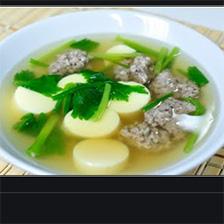

In [ ]:
url = "https://github.com/GemmyTheGeek/FoodyDudy/raw/main/images/test/03/0289.jpg"
image = Image.open(requests.get(url, stream=True).raw)
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
image

In [ ]:
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [ ]:
pred_idx = logits.argmax(-1).item()
print("Predicted class:", id2food[model.config.id2label[pred_idx]])

Predicted class: taohoo_moosup


## Prediction: Using pipeline API

นอกจากนั้น `transformers` ยังมี `pipeline` ที่เราเลือกชนิดของ pipeline แบบต่างๆ เช่น `image-classification` ทำให้การทำนายทำได้สะดวกยิ่งขึ้น 

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", model_name)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
pipe(image)

[{'score': 0.9926163554191589, 'label': '03'},
 {'score': 0.006231394596397877, 'label': '04'},
 {'score': 0.00036008251481689513, 'label': '02'},
 {'score': 0.00020661753660533577, 'label': '10'},
 {'score': 0.0001315288827754557, 'label': '26'}]

In [ ]:
[{"score": l["score"], "label": id2food[l["label"]]} for l in pipe(image)]

[{'score': 0.9926163554191589, 'label': 'taohoo_moosup'},
 {'score': 0.006231394596397877, 'label': 'mara_yadsai'},
 {'score': 0.00036008251481689513, 'label': 'liang_curry'},
 {'score': 0.00020661753660533577, 'label': 'palo_egg'},
 {'score': 0.0001315288827754557, 'label': 'tom_ka_gai'}]

## Create gradio application for prediction

สุดท้ายแล้วเราสามารถนำโค้ดทั้งหมดมาจัดเรียง และ deploy ด้วย Gradio application ทั้งนี้เราเพียงต้องเขียน
- ฟังก์ชั่นเพื่อ inference โดยมี `id2food` เพื่อเปลี่ยน class ที่ทำนายเป็นชื่ออาหาร
- input ซึ่งเป็นชนิดภาพ `gr.inputs.Image()`
- output เป็น label ที่ทำนายได้ `gr.outputs.Label(num_top_classes=5)`
- ประกอบร่างกันเข้ามาด้วย `gr.Interface`

In [ ]:
import gradio as gr


food_list = [
    'green_curry', 'tepo_curry', 'liang_curry', 'taohoo_moosup', 'mara_yadsai',
    'masaman', 'orange_curry', 'cashew_chicken', 'omelette', 'sunny_side_up',
    'palo_egg', 'sil_egg', 'nun_banana', 'kua_gai', 'cabbage_fish_sauce',
    'river_prawn', 'shrimp_ob_woonsen', 'kanom_krok', 'mango_sticky_rice', 'kao_kamoo',
    'kao_klook_kapi', 'kaosoi', 'kao_pad', 'kao_pad_shrimp', 'chicken_rice',
    'kao_mok_gai', 'tom_ka_gai', 'tom_yum_kung', 'tod_mun', 'poh_pia',
    'pak_boong_fai_daeng', 'padthai', 'pad_krapao', 'pad_si_ew', 'pad_fakthong',
    'eggplant_stirfry', 'pad_hoi_lai', 'foithong', 'panaeng', 'yum_tua_ploo',
    'yum_woonsen', 'larb_moo', 'pumpkin_custard', 'sakoo_sai_moo', 'somtam',
    'moopoing','satay', 'hor_mok'
]
id2food = {str(i).zfill(2): f for i, f in enumerate(food_list)}


def inference(gr_input):
    """Inference function from gradio input."""
    image = Image.fromarray(gr_input.astype("uint8"), "RGB")
    predictions = pipe(image)
    predictions = {id2food[l["label"]]: l["score"] for l in predictions}
    return predictions

In [ ]:
inputs = gr.inputs.Image()
outputs = gr.outputs.Label(num_top_classes=5)

interface = gr.Interface(
    fn=inference, inputs=inputs, outputs=outputs, interpretation="default",
).launch(debug="True")

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.
